### Data exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [106]:
raw_data = pd.read_csv('data/processed_cleveland_data.csv')
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
column_a    303 non-null int64
column_b    303 non-null bool
column_c    303 non-null int64
column_d    303 non-null int64
column_e    303 non-null int64
column_f    303 non-null bool
column_g    303 non-null int64
column_h    303 non-null int64
column_i    303 non-null bool
column_j    303 non-null float64
column_k    303 non-null int64
column_l    299 non-null float64
column_m    301 non-null float64
column_n    303 non-null int64
dtypes: bool(3), float64(3), int64(8)
memory usage: 27.0 KB
None


,column_a,column_b,column_c,column_d,column_e,column_f,column_g,column_h,column_i,column_j,column_k,column_l,column_m,column_n
0,63,True,1,145,233,True,2,150,False,2.3,3,0.0,6.0,0
1,67,True,4,160,286,False,2,108,True,1.5,2,3.0,3.0,2
2,67,True,4,120,229,False,2,129,True,2.6,2,2.0,7.0,1
3,37,True,3,130,250,False,0,187,False,3.5,3,0.0,3.0,0
4,41,False,2,130,204,False,2,172,False,1.4,1,0.0,3.0,0


Let's rename the columns to make further processing easier. We should also convert the target column to have just two values: we're interested in finding the presence of heart disease, rather than classifying the severity of the disease.

In [107]:
def preprocess(data):
    renamed = data.rename(index=str, columns={"column_a": "age", "column_b": "sex", "column_c": "chest_pain",
                          "column_d": "trestbps", "column_e": "cholesterol", "column_f": "fasting_bsugar", 
                          "column_g": "restecg", "column_h": "thalach", "column_i": "exercise_angina", 
                          "column_j": "oldpeak", "column_k": "slope", "column_l": "colored_vessels",
                          "column_m": "thal", "column_n": "target"})
    renamed.target = renamed.target.replace(to_replace=[2,3,4], value=1)    
    return renamed

data = preprocess(raw_data)

We can notice that there are 4 entries that have null values in column_l (attribute _ca_: number of major vessels (0-3) colored by flourosopy). There are another 2 entries with null values in column_m (attribute _thal_: heart rate defect). We could drop these instances from the `DataFrame`, but I'm not yet sure it is necessary.

In [108]:
data = data.dropna(subset=['thal'])
data = data.fillna(value=0, axis=0) # Fill colored_vessels na values with 0

Looking at the description of the data, we can see that both colored_vessels and thal are float. I think they would be more suitable as ints. The first represents the number of major vessels coloured by fluoroscopy, while the second is one of 3 numbers representing if the heart rate is normal (so it's a categorical attribute).

In [109]:
data['colored_vessels'] = data['colored_vessels'].astype('int')
data['thal'] = data['thal'].astype('int')

Let's check our changes and see some basic stats of the numeric columns:

In [110]:
print(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 302
Data columns (total 14 columns):
age                301 non-null int64
sex                301 non-null bool
chest_pain         301 non-null int64
trestbps           301 non-null int64
cholesterol        301 non-null int64
fasting_bsugar     301 non-null bool
restecg            301 non-null int64
thalach            301 non-null int64
exercise_angina    301 non-null bool
oldpeak            301 non-null float64
slope              301 non-null int64
colored_vessels    301 non-null int32
thal               301 non-null int32
target             301 non-null int64
dtypes: bool(3), float64(1), int32(2), int64(8)
memory usage: 26.7+ KB
None


,age,chest_pain,trestbps,cholesterol,restecg,thalach,oldpeak,slope,colored_vessels,thal,target
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.451827,3.156146,131.714286,246.936877,0.990033,149.700997,1.043189,1.601329,0.667774,4.734219,0.458472
std,9.067258,0.962048,17.655729,51.859869,0.994937,22.860817,1.163384,0.616872,0.935908,1.939706,0.499102
min,29.000000,1.000000,94.000000,126.000000,0.000000,71.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,3.000000,120.000000,211.000000,0.000000,134.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,3.000000,130.000000,242.000000,1.000000,153.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,4.000000,140.000000,275.000000,2.000000,166.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,4.000000,200.000000,564.000000,2.000000,202.000000,6.200000,3.000000,3.000000,7.000000,1.000000


The next step is visualising the attributes to better understand them.

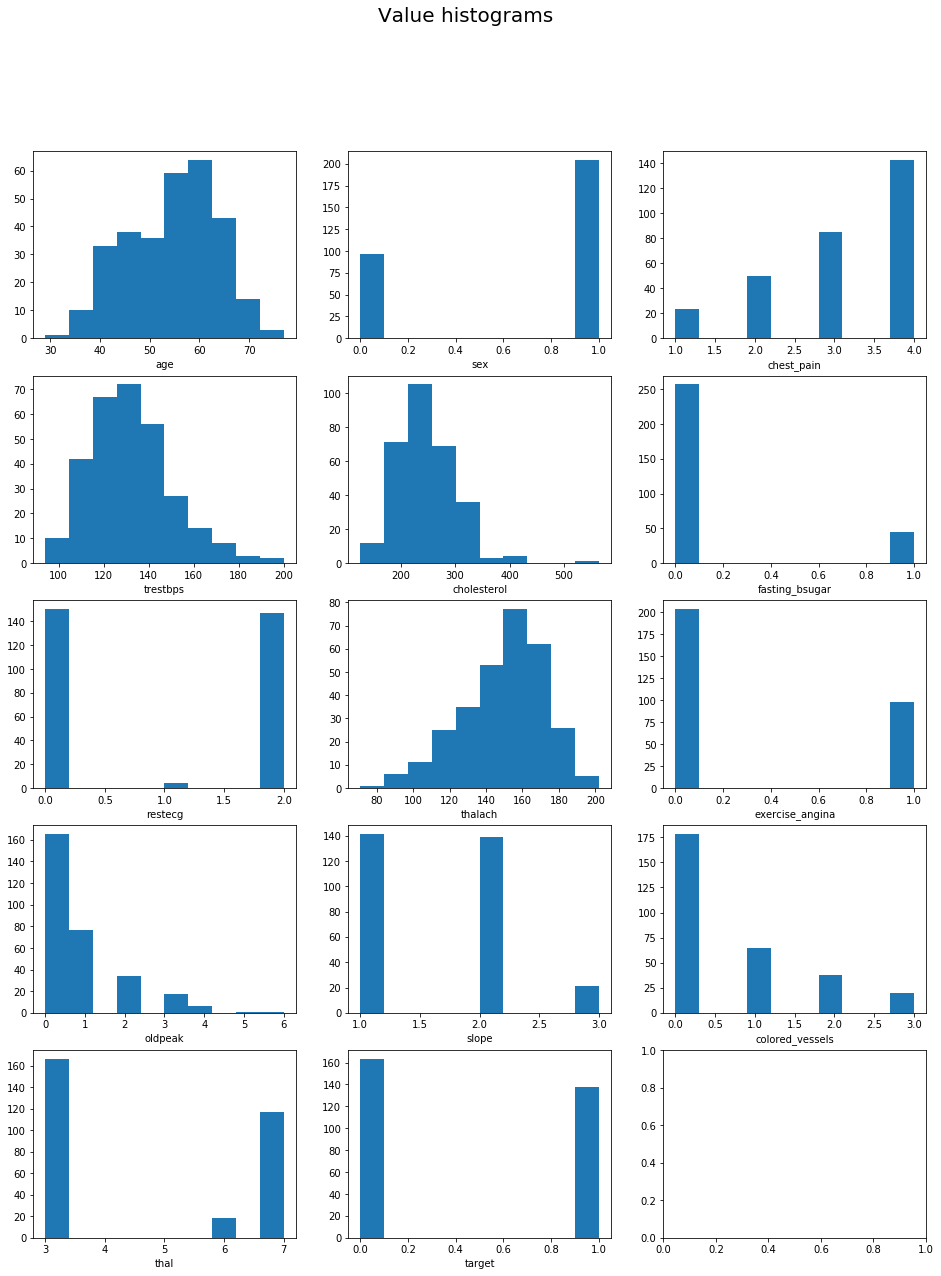

In [8]:
fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(16,20))
fig.suptitle('Value histograms', fontsize=20)
ax = ax.flatten()

for i, col in enumerate(list(data)):
    ax[i].hist(x=data[col].astype(int))
    ax[i].set_xlabel(col) 

There are several categorical attributes: sex, fasting_bsugar, chest_pain, exercise_angina, restecg, colored_vessels, thal and slope. These have to be numerically encoded. We could consider one-hot encoding for attributes with more than 2 categories that do not have a natural ordering (such as chest_pain, slope, thal). 

### Decision tree based models

In [116]:
x = data.loc[:, :'thal'].values
y = data.loc[:, 'target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y)


def fit_and_print_performance(model):
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train) # for MAE
    pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    mae_train = mean_absolute_error(y_train, train_pred)
    mae_test = mean_absolute_error(y_test, pred)
    print('Accuracy on test: {0:.4f}'.format(accuracy), '\nMAE train: {0:.4f}'.format(mae_train),
         '\tMAE test: {0:.4f}'.format(mae_test))

In [81]:
tree = DecisionTreeClassifier()
fit_and_print_performance(tree)

Accuracy on test: 0.4737 
MAE train: 0.0000 	MAE test: 0.8421


Let's visualise the tree. For the following code to work, we need `graphviz` installed in the environment.

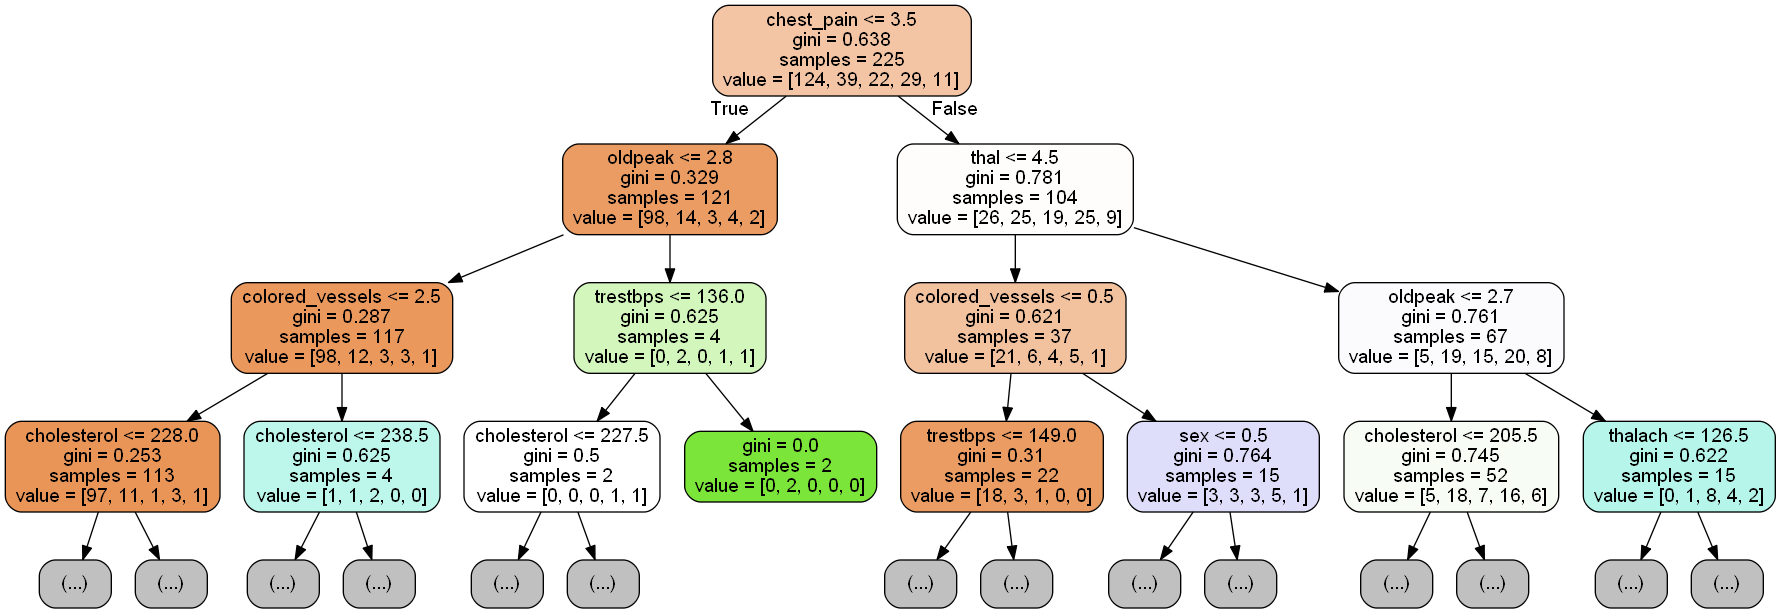

In [82]:
from sklearn.tree import export_graphviz
from IPython.display import Image, display


with open('tree.dot', 'w+') as dotfile:
    export_graphviz(tree, max_depth=3, out_file=dotfile, rounded=True, filled=True, feature_names=list(data)[:-1])

# Convert file to png
!dot -Tpng tree.dot -o tree.png
# Display in notebook
display(Image("tree.png"))

Visualising decision trees trained on a dataset is a good way to see which attributes are the most important. The attributes found at the root of the tree are the ones with the largest predictive value.

Let's try a few ensemble methods and visualise the feature importances found by them.

In [117]:
# Fit random forest
forest = RandomForestClassifier(n_estimators=100)
fit_and_print_performance(forest)

Accuracy on test: 0.8421 
MAE train: 0.0000 	MAE test: 0.1579


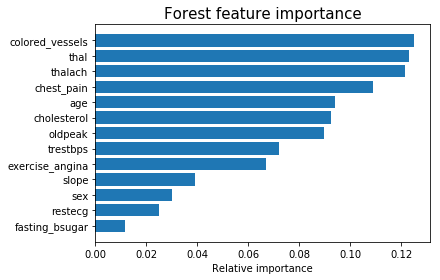

In [65]:
def plot_feature_importance(importances, modelname):
    # Sort attributes in order of importance
    names_imps = list(zip(list(data), importances))
    names_imps = sorted(names_imps, key=lambda tup: tup[1])
    names, imps = zip(*names_imps)
    
    # Plot a horizontal bar chart
    fig, ax = plt.subplots()
    indexes = np.arange(13) 
    ax.barh(indexes, width=imps, tick_label=names, height=0.8)
    ax.set_xlabel('Relative importance')
    ax.set_title(modelname + ' feature importance', fontsize=15)

plot_feature_importance(forest.feature_importances_, 'Forest')

Accuracy on test: 0.8289 
MAE train: 0.0000 	MAE test: 0.1711


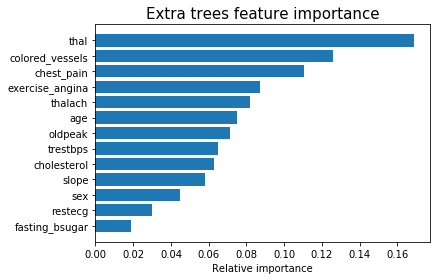

In [118]:
# Fit extra trees
extra = ExtraTreesClassifier(n_estimators=100)
fit_and_print_performance(extra)
plot_feature_importance(extra.feature_importances_, 'Extra trees')

Accuracy on test: 0.8553 
MAE train: 0.0000 	MAE test: 0.1447


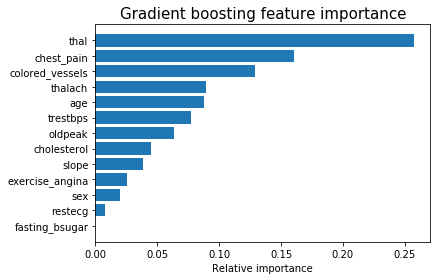

In [119]:
gdboost = GradientBoostingClassifier(n_estimators=100)
fit_and_print_performance(gdboost)
plot_feature_importance(gdboost.feature_importances_, 'Gradient boosting')

Random forest have a better performance than a single decision tree. The reason for that is because it averages out predictions over several trees. Because each tree is trained on a different subset of the data, it makes mistakes on different instances.

Extra trees are faster to train than random forests because the threshold at which instances are split at each node is chosen randomly. This also makes extra trees more resilient and harder to overfit. However, in our case we have a very small dataset so speed is not an issue.

Gradient boosting is the most interesting ensemble out of these because each additional decision tree is trained on the residual errors of its predecessor. On this dataset however, it doesn't have a better performance than random forest.

###### Feature importance
The importances vary across the three ensemble methods and across different runs but we can say that, generally, the most important features are: colored_vessels, thal, chest_pain, thalach, age, cholesterol, and oldpeak.

Knowing this is important because it also allows us to understand the quality of other datasets.

### Other models

In [120]:
fit_and_print_performance(LogisticRegression(solver='liblinear')) # regularisation is l2 by default

Accuracy on test: 0.8816 
MAE train: 0.1422 	MAE test: 0.1184


In [121]:
fit_and_print_performance(SVC(kernel='linear'))

Accuracy on test: 0.8421 
MAE train: 0.1378 	MAE test: 0.1579


In [122]:
fit_and_print_performance(SVC(kernel='rbf', gamma='scale'))

Accuracy on test: 0.6579 
MAE train: 0.2044 	MAE test: 0.3421


It looks like logistic regression has the highest accuracy. The polynomial SVM (with rbf kernel) has very low accuracy, as it's probably overfitting. I suspect that the dataset is linearly separable.

The next step would be to include more data. There are 4 csv files with 923 samples in total. However, the files are of varied quality, with some of them having more missing values. A solution to this is to train on fewer attributes (ignoring ones with lots of missing values).

## More data

Append all csv files into one `DataFrame`.

In [111]:
import os

csvfiles = ['processed_hungarian_data.csv', 'processed_switzerland_data.csv', 'processed_va_data.csv']
alldata = data

for file in csvfiles:
    df = pd.read_csv('data/' + file)
    df = preprocess(df)
    alldata = alldata.append(df)
    

print(alldata.info())

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 199
Data columns (total 14 columns):
age                918 non-null int64
sex                918 non-null bool
chest_pain         918 non-null int64
trestbps           859 non-null float64
cholesterol        888 non-null float64
fasting_bsugar     828 non-null float64
restecg            916 non-null float64
thalach            863 non-null float64
exercise_angina    863 non-null float64
oldpeak            856 non-null float64
slope              609 non-null float64
colored_vessels    311 non-null float64
thal               434 non-null float64
target             918 non-null int64
dtypes: bool(1), float64(10), int64(3)
memory usage: 101.3+ KB
None


Well this is disappointing, some of the attributes we found to be the most important have the most missing values (colored_vessels and thal). We now have two options: we either decide not to use the other three files, or we retrain our models without the colored_vessels attribute on the few instances with values for thal. This would add a third more training instances, so it is a relevant amount.

I will go with the second choice.

In [112]:
alldata = alldata.dropna(subset=['thal'])
alldata = alldata.drop(['fasting_bsugar', 'slope', 'colored_vessels'], axis=1)
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 0 to 197
Data columns (total 11 columns):
age                434 non-null int64
sex                434 non-null bool
chest_pain         434 non-null int64
trestbps           430 non-null float64
cholesterol        432 non-null float64
restecg            434 non-null float64
thalach            432 non-null float64
exercise_angina    432 non-null float64
oldpeak            427 non-null float64
thal               434 non-null float64
target             434 non-null int64
dtypes: bool(1), float64(7), int64(3)
memory usage: 37.7+ KB


We should fill the remaining missing values with the averages in each column. We can get the means from the statistical description of the dataset from the beginning of this notebook.

In [114]:
alldata.trestbps = alldata.trestbps.fillna(value=131.71, axis=0)
alldata.cholesterol = alldata.cholesterol.fillna(value=246.93, axis=0)
alldata.thalach = alldata.thalach.fillna(value=149.70, axis=0)
alldata.exercise_angina = alldata.exercise_angina.fillna(value=0, axis=0)
alldata.oldpeak = alldata.oldpeak.fillna(value=0, axis=0)
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 0 to 197
Data columns (total 11 columns):
age                434 non-null int64
sex                434 non-null bool
chest_pain         434 non-null int64
trestbps           434 non-null float64
cholesterol        434 non-null float64
restecg            434 non-null float64
thalach            434 non-null float64
exercise_angina    434 non-null float64
oldpeak            434 non-null float64
thal               434 non-null float64
target             434 non-null int64
dtypes: bool(1), float64(7), int64(3)
memory usage: 37.7+ KB


### Fit models again

In [123]:
x = alldata.loc[:, :'thal'].values
y = alldata.loc[:, 'target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y)

fit_and_print_performance(LogisticRegression(solver='liblinear'))

Accuracy on test: 0.8349 
MAE train: 0.1477 	MAE test: 0.1651
